# Sampling importance resampling (SIR) algorithm 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym
from sympy import *
from tabulate import tabulate
from numpy import array, diag, dot, maximum, empty, repeat, ones, sum
from scipy.special import factorial
import seaborn as sns
from scipy.stats import gamma, chi2
from scipy import stats
import sympy as sym
from scipy.stats import norm
from scipy.stats import poisson
from scipy.stats import uniform
from scipy.stats import lognorm
import warnings
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects
from rpy2.robjects import numpy2ri
from rpy2.robjects import pandas2ri
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
from scipy import integrate
from sklearn import preprocessing
numpy2ri.activate()
vgam = importr('VGAM')
sns.set()
warnings.filterwarnings("ignore")
np.random.seed(21091982)

# 1. (20 Points)Implementing Example 6.3 on page 165 of Computational Statistics, reproduce FIGURE 6.7.


## We will use vgam to run r functions in python (since python does not have slash distribution, we will import it from r)

In [2]:
## INITIAL VALUES
m = 100000
n = 5000
y = np.random.normal(0,1,m)
v = vgam.rslash(m)

## We need the functions to calculate weights:

In [3]:
def w(x):
    out = vgam.dslash(x)/norm.pdf(x,0,1)
    out = out/sum(out)
    return out

In [4]:
def w2(x):
    out = norm.pdf(x,0,1)/vgam.dslash(x)
    out = out/sum(out)
    return out

## Calculate weightd and resample

In [5]:
rpy2.robjects.numpy2ri.activate()
Y = ro.r.matrix(y)
#V = ro.r.matrix(v)
V=v
weights = w(Y)
weights = np.reshape(np.array(weights),100000)
x=np.random.choice(y,size=n,replace=True,p=weights)
weights2 = w2(V)
weights2 = np.reshape(np.array(weights2),100000)
v = np.reshape(np.array(v),100000)
u=np.random.choice(v,size=n,replace=True,p=weights2)

In [6]:
x_1=np.linspace(-10,10,10000)
x_2 = ro.r.matrix(x_1)
y_1=vgam.dslash(x_2)
y_1=np.reshape(np.array(y_1),10000)
y_2=norm.pdf(x_1,0,1)

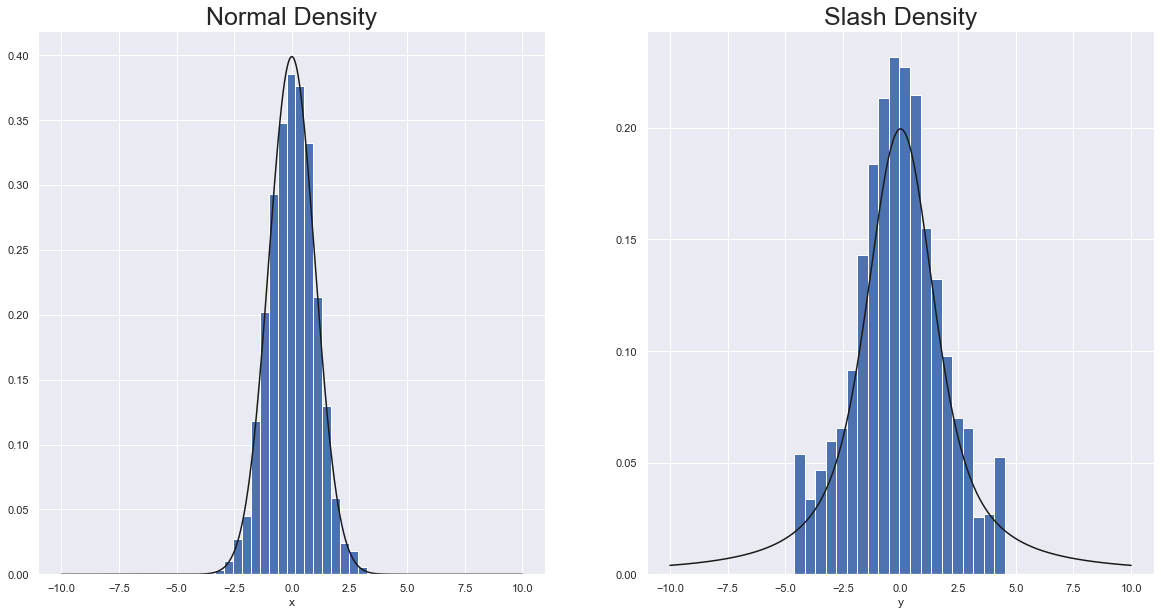

In [7]:
plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
plt.hist(u,20,density=True)
plt.plot(x_1, y_2, 'k-')
plt.title('Normal Density',fontsize=25)
plt.xlabel('x')


plt.subplot(1, 2, 2)
plt.hist(x,20,density=True)
plt.plot(x_1, y_1, 'k-')
plt.title('Slash Density',fontsize=25)
plt.xlabel('y')


plt.show()

## The left panel shows a histogram of approximated raws from a standard normal density obtained via SIR with a slash distribution envelope.The right panel shows a histogram of approximated raws from a slash density obtained via SIR using a normal envelope.The solid lines show the target densities.

# 2. (20 Points) Implementing SIR algorithm in Example 6.4 on page 166 for the case of Example 6.2. Report your estimated posterior mean and posterior standard deviation. Show the generated random samples by superimposing the following three items in a single plot:


# (a) a relative frequency histogram with appropriate number of bars for your generated random numbers with sample size n = 5000; 
# (b) an estimated probability density curve based on the generated random numbers; (c) the true posterior probability density curve
# (c) the true posterior probability density curve


## Producing 100000 samples by log normal distribution

In [8]:
samples=np.random.RandomState(21091982).lognormal(np.log(4),0.5,100000)

In [9]:
samples

array([ 4.59043128, 11.54779696,  4.03818347, ...,  2.91508778,
        2.39126771,  5.55978154])

## Data from example 6.2

In [10]:
x=np.array([8,3,4,3,1,7,2,6,2,7])
x.shape

(10,)

## We will define the likelihhod function based on poisson distribution:

In [11]:
def likelihood(x,lambda_):
    L=np.zeros(len(lambda_))
    for i in range (len(lambda_)):
        L[i] = np.prod(poisson.pmf(x,lambda_[i]))       
    return L

## Sampling

In [12]:
L = likelihood(x,samples)
f= np.random.choice(samples, size = n, replace=True, p=L/sum(L))

## Estimated posterior mean and standard deviation

In [13]:
np.mean(f)

4.2777489506751385

In [14]:
np.std(f)

0.6129900424638031

## Now, we can calculate the posterior

In [15]:
lambda1 = np.linspace(0,10,1000)
pr = integrate.simps(lognorm.pdf(lambda1,1, loc=0.5,scale=np.log(4))*likelihood(x,lambda1),lambda1)
posterior = lognorm.pdf(lambda1,1, loc=0.5,scale=np.log(4))*likelihood(x,lambda1)/pr

In [16]:
np.mean(posterior)

0.0999000000000311

In [17]:
np.std(posterior)

0.18585541418828003

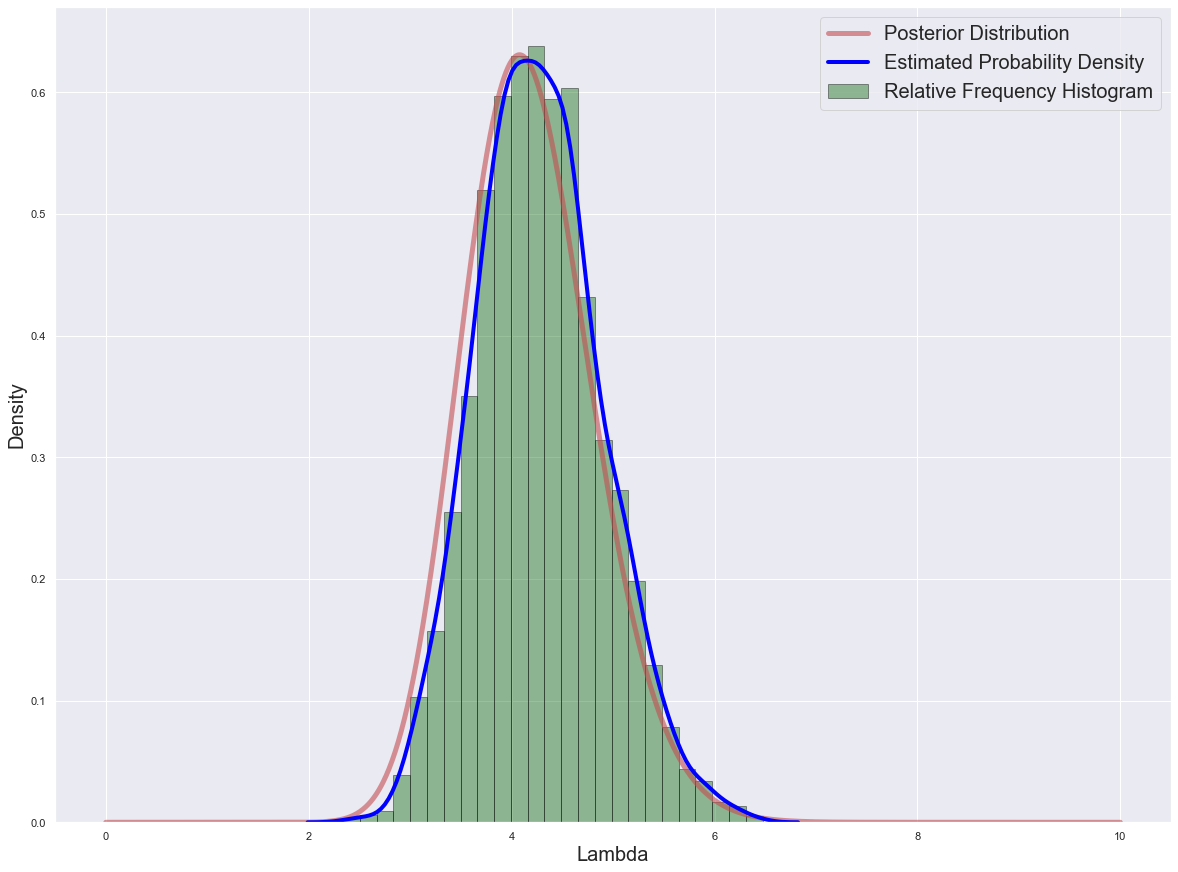

In [18]:
plt.figure(figsize=(20,15))
plt.plot(lambda1,posterior ,'r-', lw=5, alpha=0.6, label='Posterior Distribution')

sns.distplot(f, hist=True, kde=True, 
             bins=int(25), color = 'darkgreen', 
             hist_kws={'edgecolor':'black',"label": "Relative Frequency Histogram"},
             kde_kws={"label": "Estimated Probability Density",'linewidth': 4,'color':'blue'})
plt.xlabel('Lambda',fontsize=20)
plt.ylabel('Density',fontsize=20)
plt.legend(prop={"size":20})
plt.show()